<a href="https://colab.research.google.com/github/tanyakuznetsova/Image-Restoration-with-Gibbs-sampler/blob/main/Image_Restoration_with_Gibbs_sampler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising an image with a Bayesian approach

In this notebook, I will denoise a black and white image using Bayesian inference with a very simple prior distribution.

The image I'll be working with is a Japanese woodblock print of a frog that deliberately had 50% Gaussian grain added to it in order to corrupt it and make it a fun challenge to test how a Gibbs sampler can restore it.

In [1]:
#preliminary library installation

!pip install opencv-python -q

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from google.colab import drive

In [3]:
#drive.flush_and_unmount()

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


The following routine loads an image. I will be working with ```frog-50.jpg```, the file that contains a considerable and noticeable level of grain added to it. The image is 300x300 pixels in grayscale. The function ```load_image()```  binarizes it and embeds it in the center of a 300x300 image, the edges of which are padded with zeroes to make computations easier.

To show the original image, ```load_image_no_binarization``` is used.

In [5]:
# Subroutine for loading an image
# Any pixel with value >= 128 is set to +1
# Any pixel with value < 128 is set to -1
def load_image(filename):
  img = cv2.imread(filename,
                   cv2.IMREAD_GRAYSCALE
                   )
  img = img/255.0
  img[img>=0.5]=1.0
  img[img<0.5]=0.0
  img = img*2-1
  return img

In [6]:
def load_image_no_binarization(filename):
  img = cv2.imread(filename,
                   cv2.IMREAD_GRAYSCALE
                   )
  img = img/255.0

  return img

In [7]:
#uploaded = files.upload()

#for filename in uploaded.keys():
    #print('User uploaded file "{name}" with length {length} bytes'.format(
        #name=filename, length=len(uploaded[filename])))

# Load in both the degraded image and the original
img = load_image("/content/drive/My Drive/Colab Notebooks/noise/frog-50.jpeg")
original = load_image_no_binarization("/content/drive/My Drive/Colab Notebooks/noise/frog-clean.jpeg")
M, N = img.shape[0], img.shape[1]

# Create a version of img that is padded with zeros all around
padded_image = np.zeros((img.shape[0]+2, img.shape[1]+2)) #Padding image to make some computations easier
padded_image[1:-1,1:-1] = img

In [8]:
padded_image.shape

(302, 302)

Let's see what both the original and the corrupted images look like:

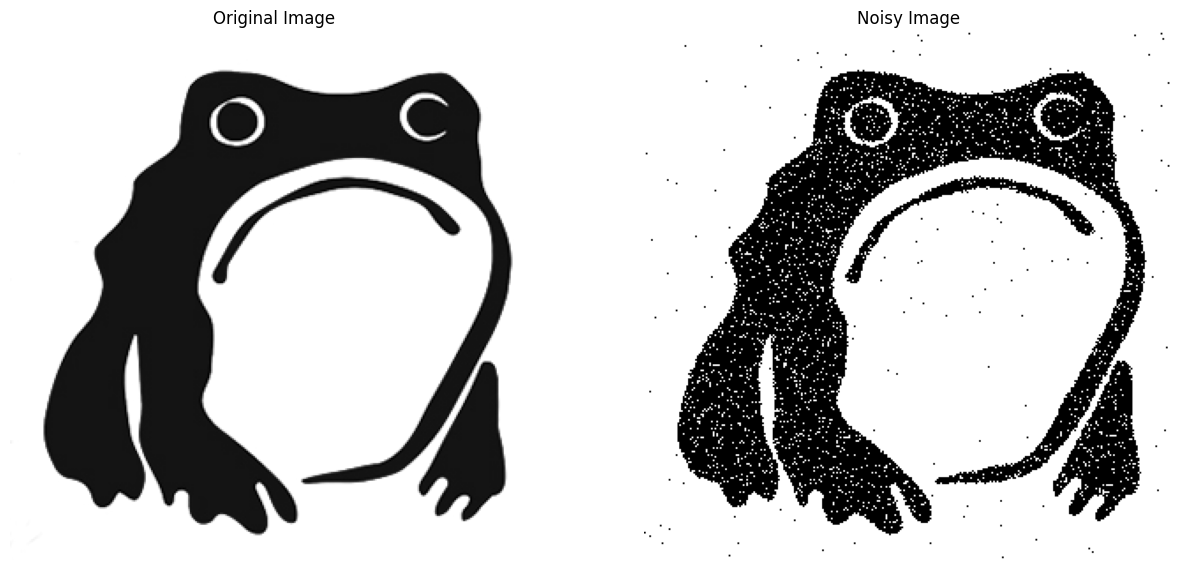

In [9]:
plt.figure(figsize = (15, 15))

plt.subplot(1, 2, 1)
plt.imshow(original, cmap = 'gray')
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.title('Noisy Image')

plt.show()

# The Probabilistic Model

Let $X$ denote the corrupted image (of size $M \times N$) and $Y$ the original that we wish to reconstruct.


Let $p = (i,j)$ denote a position in the image and let $X_p = X(i,j), Y_p = Y(i,j)$ be the values of $X$ and $Y$ at that location. These values are -1 or +1, assigned earlier. Write $p \sim q$ if $p,q$ are neighboring pixels; note that pixel $p = (i,j)$ has neighbors ${\mathcal{N}}(p) = \{ (i-1,j), (i+1,j), (i,j-1), (i,j+1)\}$.

Then, given a pixel $Y_{ij}$ with neighbors $N_p$:

$$w = Y_{ij} + \Sigma_{p \in N_p} Y_p $$

and the probability of the positive class is calculated as follows: $\dfrac {e^w}{1 + e^w}$

This corresponds to a Gibbs distribution with a linear potential.

In the context of the Gibbs sampling algorithm, I will use the variable Y as the state of the image during the reconstruction, or denoising process. In the next cell, it is initalized randomly to give the algorithm a starting point:

In [10]:
#initialize Y at random
Y = np.random.choice([-1, 1], size=padded_image.shape)

The algorithm below refines the state of Y based on the conditional distrubution given by the noisy image. The Gibbs sampler will iteratively update each pixel based on its neighbors and the potential function $\phi(u, v) = e^{u + v}$. As more iterations are performed, the Markov Chain refines the estimate of the underlying image; the goal for it is to converge to a state where Y represents a reconstructed version of the original image.

In [11]:
def gibbs_sampling(Y, img, num_samples):
    for _ in range(num_samples):
        for i in range(1, M + 1):
            for j in range(1, N + 1):
                markov_blanket = [
                    Y[i - 1, j],
                    Y[i + 1, j],
                    Y[i, j - 1],
                    Y[i, j + 1],
                    img[i, j]] #neighbor pixels + pixel in the corrupted img

                w = markov_blanket[-1] + sum(markov_blanket[:-1])

                prob_y_plus1 = math.exp(w) / (1 + math.exp(w))

                # sampling Y[i, j] from the conditional distribution
                Y[i, j] = np.random.choice([1, -1], p=[prob_y_plus1, 1 - prob_y_plus1])

    return Y

Using the following function allows you to essentially output Y after a certain number of sampling iterations and see how the algorithm behaves at different stages as it moves towards convergence:

In [12]:
def denoised_img(n):
  denoised_img = gibbs_sampling(Y,
                                padded_image,
                                num_samples = n)

  plt.figure(figsize = (8, 8))
  plt.imshow(denoised_img[1:M, 1:N],
             cmap = 'gray')  #need to overtly specify this, otherwise it returns an image in color
  plt.axis('off')

  plt.title(f"After {n} Gibbs Sampling Iterations")
  plt.show()

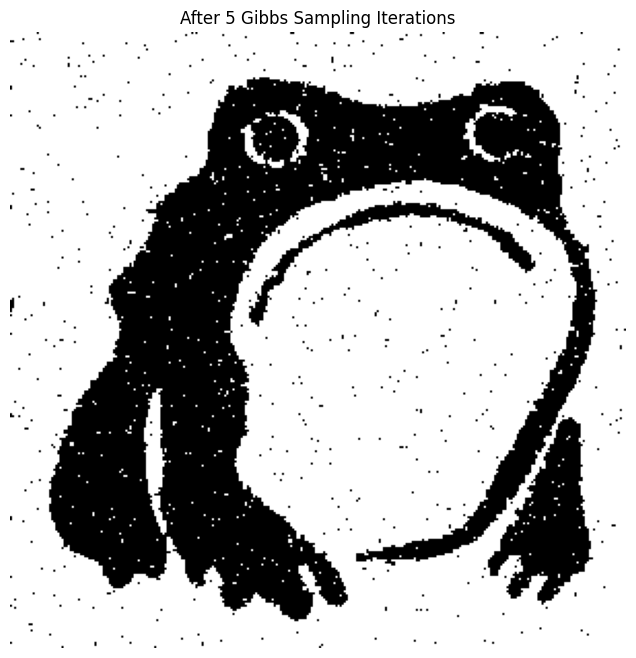

In [13]:
denoised_img(5)

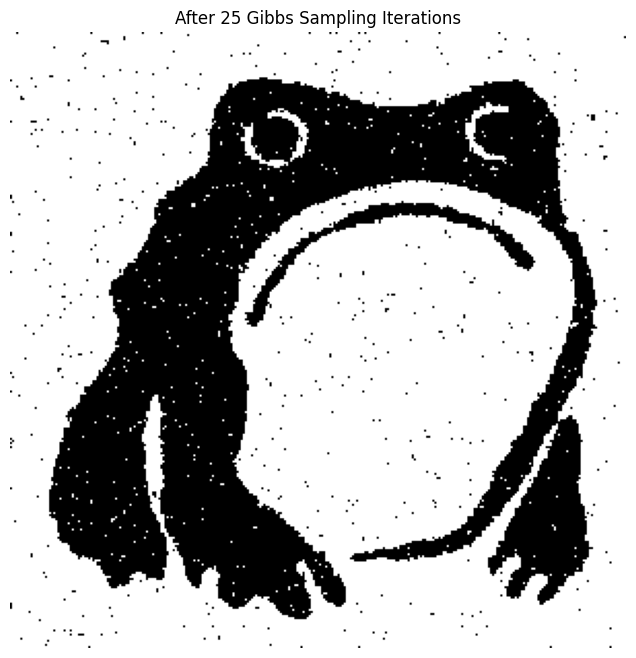

In [14]:
denoised_img(25)

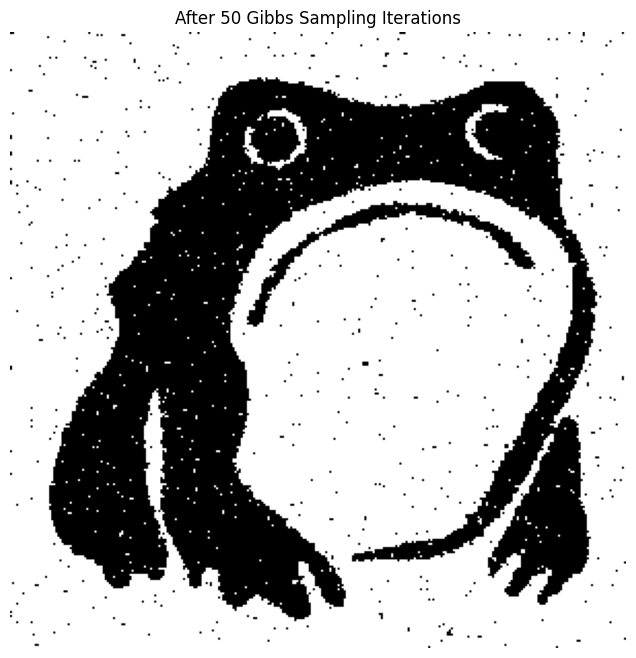

In [15]:
denoised_img(50)

This is moving in the right direction. The following block is the full algorithm that is executed a specified number of times (```num_samples```), and returns the resulting denoised image.



In [17]:
def gibbs_denoising(Y, img, num_samples):

    pixel_sums = np.zeros_like(Y, dtype=int)

    for _ in range(num_samples):
        for i in range(1, M + 1):
            for j in range(1, N + 1):
                markov_blanket = [
                    Y[i - 1, j],
                    Y[i + 1, j],
                    Y[i, j - 1],
                    Y[i, j + 1],
                    img[i, j]] #neighbor pixels + pixel in the corrupted img

                w = markov_blanket[-1] + sum(markov_blanket[:-1])

                # Compute the conditional probability for each grayscale value
                prob_y_plus1 = math.exp(w) / (1 + math.exp(w))

                # sampling Y[i, j] from the conditional distribution
                Y[i, j] = np.random.choice([1, -1], p=[prob_y_plus1, 1 - prob_y_plus1])

                pixel_sums[i, j] += Y[i, j]

    #thresholding based on the majority of samples
    reconstructed_image = np.where(pixel_sums > 0, 1, -1)

    return reconstructed_image

In [18]:
Y = np.random.choice([-1, 1], size=padded_image.shape)

reconstructed_image = gibbs_denoising(Y,
                                     padded_image,
                                     num_samples=150)

Now that the corrupted image has undergone the denoising procedure using the Gibbs sampler, let's compare and contrast it with the noisy image:

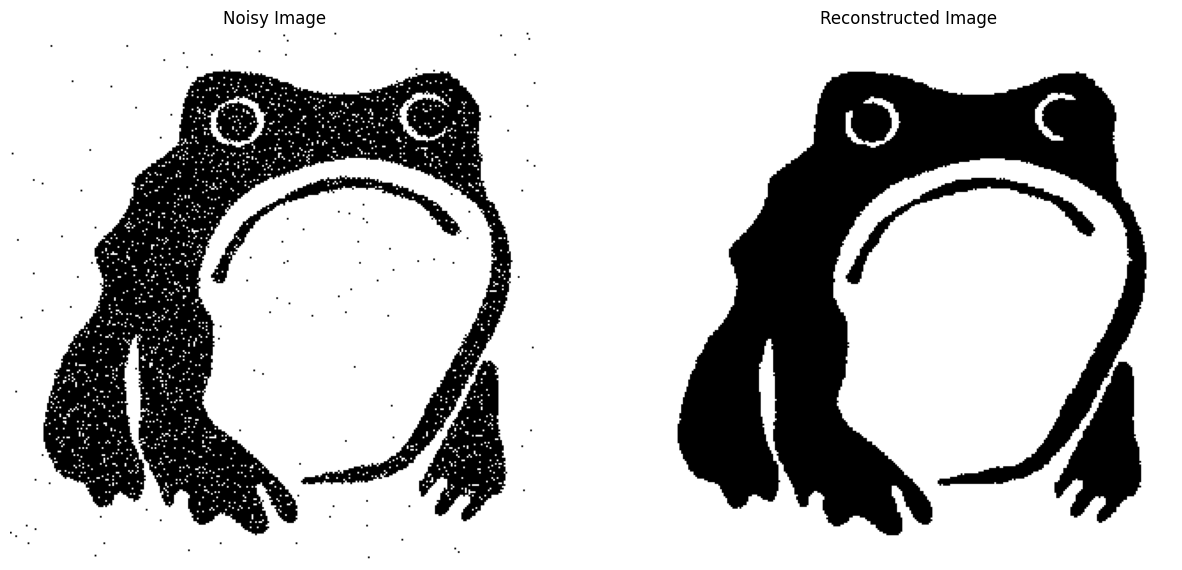

In [19]:
plt.figure(figsize = (15, 15))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.title('Noisy Image')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image[1:M, 1:N],
           cmap = 'gray')
plt.axis('off')
plt.title("Reconstructed Image")
plt.show()

The Gibbs sampler got rid of all of the added noise! When compared to the original image, the reconstructed one appears to be not as smooth around the edges, and it has lost some detail around the eyes, but all noise has been eliminated, which is pretty remarkable.

The limitation of this method is that it is quite computationally expensive: for a fairly small image of 300x300 pixels the algorithm takes about 10 minutes to execute 150 iterations. Additionally, the image I chose to demostrate this approach on is a simple black and white picture. I further simplified handling the added noise by binarizing the grayscale values (values from 0 to 128 are mapped to -1 (black), and values from 129 to 255 are mapped to +1 (white)) in the preprocessing stage. The algorithm performs considerably less well without this step.

However, with all these caveats, the Gibbs sampler is an elegant solution for certain image restoration purposes, which I showcase in this notebook.